# 第2章 提供推荐（1）
## 要点
### “人以群分法”：基于用户的协作性过滤
### “物以类聚法”：基于物品的协作性过滤
### 采用教材中的方法，通过字典实现

## 1 探索小数据集案例

### 1.1 查看原始小数据集，教材：p8

#### critics为偏好数据集，记录了每一个人对其看过影片的评价，结构为嵌套字典，包含内外键，外键为用户名称，内键为影片名称，值为对应用户对该部的评分

In [13]:
critics={'Lisa Rose':{'Lady in the Water':2.5, 'Snakes on a Plane' :3.5,
'Just My Luck':3.0, 'Superman Returns':3.5, 'You,Me and Dupree':2.5,
'The Night Listener':3.0},
'Gene Seymour':{'Lady in the Water':3.0,'Snakes on a Plane':3.5,
'Just My Luck':1.5,'Superman Returns':5.0,'The Night Listener':3.0,
'You,Me and Dupree':3.5},
'Michael Phillips':{'Lady in the Water':2.5, 'Snakes on a Plane':3.0,
'Superman Returns':3.5,'The Night Listener':4.0},
'Claudia Puig':{'Snakes on a Plane':3.5,'Just My Luck':3.0,
'The Night Listener':4.5,'Superman Returns':4.0,'You,Me and Dupree':2.5},
'Mich Lasalle':{'Lady in the Water':3.0,'Snakes on a Plane':4.0,
'Just My Luck':2.0,'Superman Returns':3.0,'The Night Listener':3.0,
'You,Me and Dupree':2.0},
'Jack Mattews':{'Lady in the Water':3.0,'Snakes on a Plane':4.0,
'The Night Listener':3.0,'Superman Returns':5.0,'You,Me and Dupree':3.5},
'Toby':{'Snakes on a Plane':4.5,'You,Me and Dupree':1.0,'Superman Returns':4.0}}

#### 偏好数据集总共包含7位不同用户的数据

In [14]:
print('评价用户数 %d'%len(critics.keys()))

评价用户数 7


#### 影片‘Snakes on a Plane’评价次数最多，共7次

In [15]:
#记录偏好数据库中影片出现批次
items_freq = {}
for p in critics.keys():
    for i in critics[p].keys():
        items_freq.setdefault(i,0)#对新的key的value值初始为0
        items_freq[i] += 1 #计数

items_freq = dict(sorted(items_freq.items(),key = lambda x:x[1],reverse = True))
items_freq

{'Snakes on a Plane': 7,
 'Superman Returns': 7,
 'You,Me and Dupree': 6,
 'The Night Listener': 6,
 'Lady in the Water': 5,
 'Just My Luck': 4}

## 1.2  根据偏好数据衡量人（物）之间的偏好相似程度

### 1.2.1 定义函数：欧氏距离相似度评价方法

In [16]:
#计算欧式距离相似度函数
from math import sqrt
def sim_distance(prefs, person1, person2):
    #获取两个人都看过的电影列表
    si = {}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1
    if len(si) == 0: return 0
    
    #计算距离
    sum_of_squares = sum([pow(prefs[person1][item] - prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])
    
    return 1/(1 + sqrt(sum_of_squares))#将1(1+欧式距离)，表示距离越大、相似度越低，反之，同时避免分母为0情况

#### 计算Lisa Rose与Gene Seymour之间的距离

In [17]:
sim_distance(critics, 'Lisa Rose', 'Gene Seymour')

0.29429805508554946

#### 将欧氏距离相似度评价法可视化，以横纵轴为指定两部片子，将同时观看过两部片子的人绘制成散点图，类同书中图2-1

In [18]:

def plot_scatter( f1, f2):
    #{p:mar,....}
    p_mark_f1 = {}
    p_mark_f2 = {}

    for p in critics.keys(): #遍历所有人
        if f1 in critics[p] and f2 in critics[p]:#同时看过指定的两部片子
            p_mark_f1[p] =  critics[p][f1] #为第1部片子建立评分字典，为横轴
            p_mark_f2[p] =  critics[p][f2] #为第2部片子建立评分字典，为纵轴


    print(p_mark_f1)
    print(p_mark_f2)

    plt.scatter(p_mark_f1.values(),p_mark_f2.values())

    note = p_mark_f1.keys()#散点图中的点用评分人来进行标注
    for i in range(len(note)):
        plt.annotate(list(note)[i], xy = (list(p_mark_f1.values())[i], list(p_mark_f2.values())[i]), xytext = (list(p_mark_f1.values())[i]+0.1, list(p_mark_f2.values())[i]+0.1)) # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    
    
    plt.xlim([0, 5])#只调x轴
    plt.ylim([0, 5])#只调y
    
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

#### 将以下两部影片之间的欧氏距离可视化

{'Lisa Rose': 2.5, 'Gene Seymour': 3.5, 'Claudia Puig': 2.5, 'Mich Lasalle': 2.0, 'Jack Mattews': 3.5, 'Toby': 1.0}
{'Lisa Rose': 3.5, 'Gene Seymour': 3.5, 'Claudia Puig': 3.5, 'Mich Lasalle': 4.0, 'Jack Mattews': 4.0, 'Toby': 4.5}


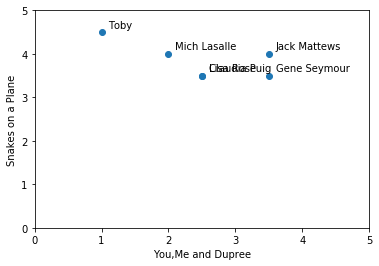

In [19]:
from matplotlib import pyplot as plt
plot_scatter('You,Me and Dupree','Snakes on a Plane')

#### 再换个角度可视化，将横纵轴互换，横纵轴为指定两个人，将两个人同时观看过的片子绘制成散点图，

In [20]:
def plot_scatter2(critics,p1, p2):
    
    #统计两个人同时打过分的片单
    f_all = {}
    for p in critics.keys():
        for f in critics[p].keys():
            f_all.setdefault(f,0)#初始化一个键值对
            f_all[f] += 1 #计数
    
    #{f:mar,....}
    f_mark_p1 = {}
    f_mark_p2 = {}

    for f in f_all.keys():
        if f in critics[p1] and f in critics[p2]:#两个人都看过该影片
            f_mark_p1[f] = critics[p1][f]
            f_mark_p2[f] = critics[p2][f]

    print(f_mark_p1)
    print(f_mark_p2)

    plt.scatter(f_mark_p1.values(),f_mark_p2.values())

    note = f_mark_p1.keys()#散点图中的点用评分人来进行标注
    for i in range(len(note)):
        plt.annotate(list(note)[i], xy = (list(f_mark_p1.values())[i], list(f_mark_p2.values())[i]), xytext = (list(f_mark_p1.values())[i]+0.1, list(f_mark_p2.values())[i]+0.1)) # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    
    plt.xlim([0, 6])#只调x轴
    plt.ylim([0, 6])#只调y
    plt.xlabel(p1)
    plt.ylabel(p2)
    plt.show()

{'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 'Superman Returns': 5.0, 'You,Me and Dupree': 3.5, 'The Night Listener': 3.0}
{'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5, 'Superman Returns': 3.5, 'You,Me and Dupree': 2.5, 'The Night Listener': 3.0}


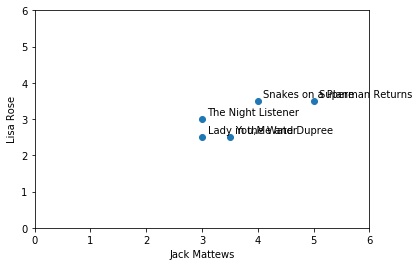

In [21]:
plot_scatter2(critics,'Jack Mattews', 'Lisa Rose')

### 1.2.2 定义函数：p系数相似度评价方法

In [22]:
def sim_pearson(prefs, p1, p2):
    si = {}
    
    #找到比较两者之间的可比较交集，如两个人共同看过的影片
    for item in prefs[p1]:
        if item in prefs[p2]:
            si[item] = 1
    n = len(si)
    if len(si) == 0: return 0 #书中疑似错误
    
    #step 1：求和
    sum1 = sum([prefs[p1][it] for it in si])
    sum2 = sum([prefs[p2][it] for it in si])
    
    #step 2: 求平方的和
    sum1Sq = sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq = sum([pow(prefs[p2][it],2) for it in si])
    
    #step 3：求乘积的和
    pSum = sum([prefs[p1][it] * prefs[p2][it] for it in si])
    
    #step 4: 乘积的和 - 和的乘积/n
    num = pSum - ( sum1 * sum2 / n)
    #step 5: (平方的和 - 和的平方)/n
    den = sqrt((sum1Sq - pow(sum1,2)/n) * (sum2Sq - pow(sum2,2)/n))
    
    if den == 0 : return 0 
    p = num / den
    
    return p

#### 计算Lisa Rose，Gene Seymour之间共同观看影片评分间的p相关性系数

In [23]:
sim_pearson(critics, 'Lisa Rose', 'Jack Mattews')

0.7470178808339965

## 1.3 “人以群分”
### 观察人与人之间的偏好相似度，并为指定人为其推荐未看过的影片

### 1.3.1 定义函数：评估指定对象与其他所有对象的相似度

In [24]:
#函数：找到与指定用户（或影片）最相似的TOP影片
def topMatches(prefs, person, n=5,similarity = sim_pearson):
    #参数1：偏好字典
    #参数2：指定用户
    #参数3：n，TOP n,缺省值为5
    #参数3：相似度算法，缺省算法为p系数，也可以使用欧氏距离
    
    s = [(similarity(prefs,person,other),other) for other in prefs if other != person]
    
    s.sort()
    s.reverse()
    return s[0:n]

#### 基于p系数计算Toby与其他所有人之间的TOP 3的相似度

In [25]:
topMatches(critics,'Toby',n=3)

[(0.9912407071619299, 'Lisa Rose'),
 (0.9244734516419049, 'Mich Lasalle'),
 (0.8934051474415647, 'Claudia Puig')]

In [32]:
topMatches(critics,'Michael Phillips',n=3)

[(1.0, 'Claudia Puig'),
 (0.40451991747794525, 'Lisa Rose'),
 (0.20459830184114206, 'Gene Seymour')]

### 1.3.2 定义函数：为指定对象进行推荐

In [26]:
#基于对象与对象之间的相似度为用户做推荐，即对指定对象没看过的影片进行推荐计算并排序，
def getRecommendations(prefs, person, similarity = sim_pearson):
    #参数1：偏好数据字典
    #参数2：指定对象
    #参数3：相似度评估方法，默认为p系数
    
    totals = {}#指定对象未看过影片加权评分字典，key-指定对象未看过的影片；value-加权评分，即其他对象评分 x 其他对象与对象自己的相似度
    simSums = {} #指定对象未看过影片、其他对象看过影片，计算这样几组对象之间相似度之和,key-指定对象未看过的影片；value-对象之间的相似度之和
    
    
    for other in prefs:#遍历其他对象
        if other == person: continue #对象自己与自己不进行比较
        sim = similarity(prefs,person,other)#评估对象与其他对象之间的相似度
        
        if sim<=0: continue #在p系数评估方法中，p<0意味着两个对象之间的呈负相关，因此对于负相关的对象无需进行推荐
        
        #找到对象与其他对象观看的影片补集，即自己没看过，而其他对象看过，进行推荐指数计算
        for item in prefs[other]:#遍历其他对象所评分的影片
            if item not in prefs[person] or prefs[person][item]==0:#找到对象没看过、其他对象看过的影片
                totals.setdefault(item,0)#初始化键值对，未看过影片-推荐加权评分
                totals[item] += prefs[other][item] * sim #赋值，其他对象评分 x 其他对象与对象自己的相似度
                
                simSums.setdefault(item,0)#初始化
                simSums[item] += sim #其他所有对象与指定对象的相似度系数求和
                
    rankings = [(total/simSums[item], item) for item,total in totals.items()]#指定对象未看过影片的推荐指数列表，用元素表示  【推荐值，未看过影片】
    
    rankings.sort()#升序排序
    rankings.reverse()#降序排序
    return rankings#返回推荐指数列表

#### 为toby没看过的影片计算推荐指数（默认采用p系数相似度评估法）

In [27]:
getRecommendations(critics,'Toby')

[(3.3477895267131017, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

#### 采用欧式距离相似度评估法计算推荐指数

In [28]:
getRecommendations(critics,'Toby',similarity = sim_distance)

[(3.457128694491423, 'The Night Listener'),
 (2.778584003814924, 'Lady in the Water'),
 (2.422482042361917, 'Just My Luck')]

## 1.4 “物以类聚”
### 基于影片之间的相似度，为指定对象推荐未看过的影片

### 1.4.1 定义函数：交换偏好数据库的内键与外键位置
#### { 人:{影片:分数},......} ----》 {影片:{人:分数},........}

In [29]:
def transformPrefs(prefs):
    #参数：转换前偏好数据集
    
    result = {} #初始化转换后数据集
    for person in prefs: #遍历每一个外键（人）
        for item in prefs[person]:#遍历每一个内键（影片）
            result.setdefault(item,{})#初始化键值对
            
            result[item][person] = prefs[person][item]#交换每个评分记录的内外键
            
    return result

In [30]:
#转换
movies = transformPrefs(critics)
movies

{'Lady in the Water': {'Lisa Rose': 2.5,
  'Gene Seymour': 3.0,
  'Michael Phillips': 2.5,
  'Mich Lasalle': 3.0,
  'Jack Mattews': 3.0},
 'Snakes on a Plane': {'Lisa Rose': 3.5,
  'Gene Seymour': 3.5,
  'Michael Phillips': 3.0,
  'Claudia Puig': 3.5,
  'Mich Lasalle': 4.0,
  'Jack Mattews': 4.0,
  'Toby': 4.5},
 'Just My Luck': {'Lisa Rose': 3.0,
  'Gene Seymour': 1.5,
  'Claudia Puig': 3.0,
  'Mich Lasalle': 2.0},
 'Superman Returns': {'Lisa Rose': 3.5,
  'Gene Seymour': 5.0,
  'Michael Phillips': 3.5,
  'Claudia Puig': 4.0,
  'Mich Lasalle': 3.0,
  'Jack Mattews': 5.0,
  'Toby': 4.0},
 'You,Me and Dupree': {'Lisa Rose': 2.5,
  'Gene Seymour': 3.5,
  'Claudia Puig': 2.5,
  'Mich Lasalle': 2.0,
  'Jack Mattews': 3.5,
  'Toby': 1.0},
 'The Night Listener': {'Lisa Rose': 3.0,
  'Gene Seymour': 3.0,
  'Michael Phillips': 4.0,
  'Claudia Puig': 4.5,
  'Mich Lasalle': 3.0,
  'Jack Mattews': 3.0}}

In [31]:
sim_pearson(movies,'You,Me and Dupree','Snakes on a Plane')

-0.6454972243679047

### 1.4.2 使用转换后的内外键，计算不同影片之间的相似度

In [21]:
#找到与Superman returns评价最相思的几部影片
topMatches(movies,'Superman Returns')

[(0.6579516949597695, 'You,Me and Dupree'),
 (0.4879500364742689, 'Lady in the Water'),
 (0.11180339887498941, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

### 1.4.3 为影片推荐评论者

In [22]:
#基于影片之间的相似程度，为影片推荐评论者
getRecommendations(movies,'Just My Luck')

[(4.0, 'Michael Phillips'), (3.0, 'Jack Mattews')]

### 1.4.4 定义函数：对所有影片进行两两相似度比较，构建全量数据比较集

In [23]:
#求物品之间的相似度
def calculateSimilarItems(prefs,n=10):
    #参数1，prefs：表示偏好字典，其中key为用户，value为{影片:评分}
    #参数2，n：缺省值为10，即查看与指定影片前10相似的其他影片
    result = {}
    
    #使用transformPrefs，将原子典的key和value调换，即key为影片，value为{用户:评分}
    itemPrefs = transformPrefs(prefs)
    
    for item in itemPrefs:
        #为每一个item找到top n相似的其他item，特别注意：教材中计算作品相似度采用的又是欧式距离法
        scores = topMatches(itemPrefs,item,n=n,similarity = sim_distance)
        result[item] = scores
    
    return result

In [24]:
itemsim = calculateSimilarItems(critics)
itemsim

{'Lady in the Water': [(0.4494897427831781, 'You,Me and Dupree'),
  (0.38742588672279304, 'The Night Listener'),
  (0.3483314773547883, 'Snakes on a Plane'),
  (0.3483314773547883, 'Just My Luck'),
  (0.2402530733520421, 'Superman Returns')],
 'Snakes on a Plane': [(0.3483314773547883, 'Lady in the Water'),
  (0.32037724101704074, 'The Night Listener'),
  (0.3090169943749474, 'Superman Returns'),
  (0.2553967929896867, 'Just My Luck'),
  (0.1886378647726465, 'You,Me and Dupree')],
 'Just My Luck': [(0.3483314773547883, 'Lady in the Water'),
  (0.32037724101704074, 'You,Me and Dupree'),
  (0.2989350844248255, 'The Night Listener'),
  (0.2553967929896867, 'Snakes on a Plane'),
  (0.20799159651347807, 'Superman Returns')],
 'Superman Returns': [(0.3090169943749474, 'Snakes on a Plane'),
  (0.252650308587072, 'The Night Listener'),
  (0.2402530733520421, 'Lady in the Water'),
  (0.20799159651347807, 'Just My Luck'),
  (0.1918253663634734, 'You,Me and Dupree')],
 'You,Me and Dupree': [(0.44

### 1.4.5 定义函数：基于影片之间的相似程度，为指定用户推荐未看过的影片

In [25]:
#基于影片与影片之间的相似度，为用户进行推荐
def getRecommendedItems(prefs,itemMatch,user):
    #参数1：偏好数据集{人：{影片：分数}}
    #参数2：影片相似度全量数据集 {指定影片：[（相似度,其他影片）,....}}
    #参数3：指定对象（人）
    
    userRatings = prefs[user]#获取指定对象的评分集合
    scores = {} #初始化权重参数求和字典 {未看过影片，求和(对应已看过影片评分 x 看过影片与未看过影片的相似度 )}
    totalSim = {} #初始化相似系数求和字典 {未看过影片：相似度求和}
    
    for (item,rating) in userRatings.items():#遍历指定对象的观看影片及评分
        for (similarity,item2) in itemMatch[item]:#遍历（相似度，其他影片）
            
            if item2 in userRatings: continue#筛选出指定对象未看过的影片
            
            if similarity<0: continue#筛选出相似度>0的组合，在p系数中，相似度<0表示负相关，故忽略
            
            scores.setdefault(item2,0)#初始化键值对
            scores[item2] += similarity*rating#权重参数求和，权重参数 = 对应已看过影片评分 x 看过影片与未看过影片的相似度 
            
            totalSim.setdefault(item2,0)#初始化相似度求和键值对
            totalSim[item2] += similarity#对相似度进行求和
            
    rankings = [(score/totalSim[item],item) for item,score in scores.items()]#未看过影片推荐指数 = 未看过影片权重参数和/与看过影片相似度和
        
    rankings.sort()#升序排序
    rankings.reverse()#降序排序
    return rankings

#### 基于物品之间的相似度为Toby进行推荐

In [26]:
getRecommendedItems(critics,itemsim,'Toby')

[(3.1667425234070894, 'The Night Listener'),
 (2.9366294028444346, 'Just My Luck'),
 (2.868767392626467, 'Lady in the Water')]

# 2 实践案例：MoiveLens数据集分析

## 2.1 查看评分数据集

#### 该评分数据总共有943个用户、1682部影片、10w条评分记录

In [27]:
for line in open('E:\\jupyter\\2-集体智慧编程\\ch2-提供推荐\\ml-100k\\u.info'):
    print(line)

943 users

1682 items

100000 ratings



#### 查看u.item中给的数据格式，该数据集记录着每一部被评论影片的信息，包括影片ID、片名、上映日期等

In [28]:
#读取电影数据
i=0
for line in open('E:\\jupyter\\2-集体智慧编程\\ch2-提供推荐\\ml-100k\\u.item'):
    print(line)
    i+=1
    if i>10 :break

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0

2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0

3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0

4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0

5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0

6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0

7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0

8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|

#### 查看u.data数据集，即评分记录，包含4列，用户ID-影片ID-评分-评分时间

In [29]:
#读取用户评分数据
i=0
p = 'E:\\jupyter\\2-集体智慧编程\\ch2-提供推荐\\ml-100k'
for line in open(p+'\\u.data'):
    print(line)
    i+=1
    if i>10 :break

196	242	3	881250949

186	302	3	891717742

22	377	1	878887116

244	51	2	880606923

166	346	1	886397596

298	474	4	884182806

115	265	2	881171488

253	465	5	891628467

305	451	3	886324817

6	86	3	883603013

62	257	2	879372434



## 2.2 加载数据集并读取格式化信息 

In [30]:
#将源数据转换为固定格式
def loadMovieLens(path):
    
    
    #获取影片标题
    movies = {}
    i=0
    for line in open(path+'\\u.item',encoding='ISO-8859-1'):#遍历文件的每一行，特别注意指明文件的编码格式，否则会报错
        (movieid,title) = line.split('|')[0:2]
        movies[movieid] = title

    
    #获取用户评分数据
    j=0
    prefs = {}
    for line in open(path+'\\u.data'):
        (userid,movieid,rating,ts) = line.split('\t')
        prefs.setdefault(userid,{})
        prefs[userid][movies[movieid]] = float(rating) #注意评分要表示为浮点数，便于计算

        
    return prefs

In [31]:
import time

path = 'E:\\jupyter\\2-集体智慧编程\\ch2-提供推荐\\ml-100k'

time_start=time.time()
prefs = loadMovieLens(path)
time_end=time.time()


print(time_end - time_start)
# for k,i in prefs.items():
#     print(k,i)
#     break

0.19360589981079102


In [32]:
#196号用户有39条评分记录
print(len(prefs['196']))

39


## 2.3 基于人与人之间的相似度对偏好数据集中的用户进行推荐

In [33]:
#基于人群相似度的推荐——获取87号用户的推荐
getRecommendations(prefs, '87')[0:30]

[(5.0, 'They Made Me a Criminal (1939)'),
 (5.0, 'Star Kid (1997)'),
 (5.0, 'Santa with Muscles (1996)'),
 (5.0, 'Saint of Fort Washington, The (1993)'),
 (5.0, 'Marlene Dietrich: Shadow and Light (1996) '),
 (5.0, 'Great Day in Harlem, A (1994)'),
 (5.0, 'Entertaining Angels: The Dorothy Day Story (1996)'),
 (5.0, 'Boys, Les (1997)'),
 (4.89884443128923, 'Legal Deceit (1997)'),
 (4.815019082242709, 'Letter From Death Row, A (1998)'),
 (4.7321082983941425, 'Hearts and Minds (1996)'),
 (4.696244466490867, 'Pather Panchali (1955)'),
 (4.652397061026758, 'Lamerica (1994)'),
 (4.538723693474813, 'Leading Man, The (1996)'),
 (4.535081339106105, 'Mrs. Dalloway (1997)'),
 (4.532337612572981, 'Innocents, The (1961)'),
 (4.527998574747076, 'Casablanca (1942)'),
 (4.510270149719864, 'Everest (1998)'),
 (4.493967755428438, 'Dangerous Beauty (1998)'),
 (4.485151301801341, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (4.463287461290221, 'Wrong Trousers, The (1993)'),
 (4.450979436941

In [34]:
#计算各影片之间的相似度，为偏好字典中每一个影片找到TOP 50相似度的其他影片，总共有943部影片，运行可能会需要些时间
itemsim = calculateSimilarItems(prefs,n=50)

In [35]:
len(prefs.keys())

943

### 2.4 基于物品与物品之间的相似度为用户进行推荐

In [36]:
#为87号用户找到top 30的推荐
getRecommendedItems(prefs,itemsim,'87')[0:30]

[(5.0, "What's Eating Gilbert Grape (1993)"),
 (5.0, 'Vertigo (1958)'),
 (5.0, 'Usual Suspects, The (1995)'),
 (5.0, 'Toy Story (1995)'),
 (5.0, 'Titanic (1997)'),
 (5.0, 'Sword in the Stone, The (1963)'),
 (5.0, 'Stand by Me (1986)'),
 (5.0, 'Sling Blade (1996)'),
 (5.0, 'Silence of the Lambs, The (1991)'),
 (5.0, 'Shining, The (1980)'),
 (5.0, 'Shine (1996)'),
 (5.0, 'Sense and Sensibility (1995)'),
 (5.0, 'Scream (1996)'),
 (5.0, 'Rumble in the Bronx (1995)'),
 (5.0, 'Rock, The (1996)'),
 (5.0, 'Robin Hood: Prince of Thieves (1991)'),
 (5.0, 'Reservoir Dogs (1992)'),
 (5.0, 'Police Story 4: Project S (Chao ji ji hua) (1993)'),
 (5.0, 'House of the Spirits, The (1993)'),
 (5.0, 'Fresh (1994)'),
 (5.0, 'Denise Calls Up (1995)'),
 (5.0, 'Day the Sun Turned Cold, The (Tianguo niezi) (1994)'),
 (5.0, 'Before the Rain (Pred dozhdot) (1994)'),
 (5.0, 'Assignment, The (1997)'),
 (5.0, '1-900 (1994)'),
 (4.875, "Ed's Next Move (1996)"),
 (4.833333333333333, 'Anna (1996)'),
 (4.8, 'Dark City 